In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
NCOLS = 4
SUFFIX = 1960
SUFFIX_STR = '_%d' % SUFFIX

In [13]:
pairs_authors_dd = dd.read_csv('data/pair_csv_%d_byAuthorIDprocessed_pairs.csv' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = pairs_authors_dd.set_index('author_id', sorted=True)
pairs_authors_dd.head()

,cits
author_id,
45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141..."
115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761..."
741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885..."
980010,"{""2150231432"": [6], ""2631558439"": [0]}"
1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167..."


In [14]:
authors_infos = dd.read_csv('data/authors_infos_full_final_%d' % SUFFIX, sep='\t', header=None, 
                            names=['author_id', 'birth_year', 'citation_count'])
authors_infos = authors_infos.set_index('author_id', sorted=True)
authors_infos.head()

,birth_year,citation_count
author_id,,
45600,1957,"[127.0, 44.0, 62.0]"
115487,1959,"[0, 0, 0, 0, 0, 1.0, 0, 0, 0]"
741248,1950,"[12.0, 9.0, 93.0, 54.0, 34.0, 30.0, 0, 1.0, 12..."
980010,1959,"[0, 6.0]"
1022030,1950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 3.0, 0, 0, 7...."


In [15]:
pairs_authors_dd = pairs_authors_dd.merge(authors_infos, left_index=True, right_index=True)
pairs_authors_dd.head()

,cits,birth_year,citation_count
author_id,,,
45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[127.0, 44.0, 62.0]"
115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 0, 0, 0, 0, 1.0, 0, 0, 0]"
741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[12.0, 9.0, 93.0, 54.0, 34.0, 30.0, 0, 1.0, 12..."
980010,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 6.0]"
1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 3.0, 0, 0, 7...."


In [16]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [28]:
authors_fos = dd.read_csv('data/authors_weights_year_%d_unfied_fos.csv' % SUFFIX, sep='\t', header=None, names=['author_id', 'weights', 'fos'], dtype={'fos':int})
# authors_fos = authors_fos.set_index('author_id', sorted=True)
print(authors_fos.head(10))

# rows_nan = authors_fos.isnull().any(axis=1)
# rows_with_nan = authors_fos[rows_nan]
# rows_with_nan

   author_id                                            weights        fos
0        859                                 {"121332964": 1.0}  121332964
1       4242  {"142362112": 0.5, "127313418": 0.111111111111...  142362112
2       7539  {"71924100": 1.5066666666666666, "86803240": 0...   71924100
3      18149                                 {"185592680": 1.0}  185592680
4      30249  {"162324750": 0.06666666666666667, "41008148":...  138885662
5      45600  {"185592680": 2.7916666666666665, "121332964":...  185592680
6      81979  {"185592680": 4.833333333333334, "86803240": 0...  185592680
7      84396               {"127413603": 1.0, "185592680": 1.0}  185592680
8      86345  {"138885662": 0.6666666666666666, "142362112":...  138885662
9     103765  {"142362112": 1.3083333333333333, "95457728": ...  142362112


In [41]:
authors_complete = pairs_authors_dd.merge(authors_fos, left_on='author_id', right_on='author_id')
authors_complete.head()

,author_id,cits,birth_year,citation_count,weights,fos
0,45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[127.0, 44.0, 62.0]","{""185592680"": 2.7916666666666665, ""121332964"":...",185592680
1,115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 0, 0, 0, 0, 1.0, 0, 0, 0]","{""138885662"": 0.21999999999999997, ""144133560""...",162324750
2,741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[12.0, 9.0, 93.0, 54.0, 34.0, 30.0, 0, 1.0, 12...","{""142362112"": 1.4791666666666665, ""71924100"": ...",86803240
3,980010,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 6.0]","{""121332964"": 0.8888888888888888, ""33923547"": ...",121332964
4,1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 3.0, 0, 0, 7....","{""138885662"": 1.7938888888888889, ""142362112"":...",17744445


In [42]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    authors_complete.to_csv('data/AuthorsMetrics_split/authors_metrics_full_%d' % SUFFIX, sep='\t', header=None, index=None, single_file=True)

[########################################] | 100% Completed |  6.2s


In [51]:
from s4_authors_stats import _step_1

authors_complete = dd.read_csv('data/AuthorsMetrics_split/authors_metrics_full_%d' % SUFFIX, sep='\t', header=None)
authors_complete.columns = ['author_id', 'cits', 'birth_year', 'citation_count', 'weights', 'fos']
authors_complete = authors_complete.set_index('author_id', sorted=True)
print(authors_complete.head())

def sum_cits(row):
    c = sum(json.loads(row['citation_count']))
    return c

authors_complete = authors_complete[authors_complete.apply(sum_cits, meta=(int), axis=1) > 0]
authors_complete.head()
# print(authors_complete.head())

                                                        cits  birth_year  \
author_id                                                                  
45600      {"1250310513": [62], "2109936750": [44], "2141...        1957   
115487     {"1235265825": [0], "1981117217": [0], "209761...        1959   
741248     {"2332184452": [10], "2988917220": [12], "5885...        1950   
980010                {"2150231432": [6], "2631558439": [0]}        1959   
1022030    {"1862885640": [0], "2118961492": [0], "212167...        1950   

                                              citation_count  \
author_id                                                      
45600                                    [127.0, 44.0, 62.0]   
115487                         [0, 0, 0, 0, 0, 1.0, 0, 0, 0]   
741248     [12.0, 9.0, 93.0, 54.0, 34.0, 30.0, 0, 1.0, 12...   
980010                                              [0, 6.0]   
1022030    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 3.0, 0, 0, 7....   

                  

,cits,birth_year,citation_count,weights,fos
author_id,,,,,
45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[127.0, 44.0, 62.0]","{""185592680"": 2.7916666666666665, ""121332964"":...",185592680
115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 0, 0, 0, 0, 1.0, 0, 0, 0]","{""138885662"": 0.21999999999999997, ""144133560""...",162324750
741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[12.0, 9.0, 93.0, 54.0, 34.0, 30.0, 0, 1.0, 12...","{""142362112"": 1.4791666666666665, ""71924100"": ...",86803240
980010,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 6.0]","{""121332964"": 0.8888888888888888, ""33923547"": ...",121332964
1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 3.0, 0, 0, 7....","{""138885662"": 1.7938888888888889, ""142362112"":...",17744445


In [52]:
# h_index, cits, n_papers, birth, max_ws, max_colabs, citation_list, colabs_cit_list, authors_id = s4.step_1(pairs_authors_dd)
# with ProgressBar():
#     s4.step_1(authors_complete).to_csv('data/AuthorsMetrics_split/authors_v2_metrics_*', sep='\t', header=None)

H, C, P, WS, WP, CL, Y, CH, FOS = s4.step_1(authors_complete)

38385it [00:04, 8166.17it/s]


In [53]:
open('results/hindex_full_%d.json' % SUFFIX,'w').write(json.dumps(H))
open('results/cits_full_%d.json' % SUFFIX,'w').write(json.dumps(C))
open('results/papers_full_%d.json' % SUFFIX,'w').write(json.dumps(P))
open('results/ws_full_%d.json' % SUFFIX,'w').write(json.dumps(WS))
open('results/wp_full_%d.json' % SUFFIX,'w').write(json.dumps(WP))
open('results/citlist_full_%d.json' % SUFFIX,'w').write(json.dumps(CL))
open('results/birth_full_%d.json' % SUFFIX, 'w').write(json.dumps(Y))
open('results/fos_full_%d.json' % SUFFIX,'w').write(json.dumps(FOS))
open('results/ch_full_%d.json' % SUFFIX, 'w').write(json.dumps(CH))

2121830

In [54]:
H = json.load(open('results/hindex_full_%d.json' % SUFFIX))
C = json.load(open('results/cits_full_%d.json' % SUFFIX))
P = json.load(open('results/papers_full_%d.json' % SUFFIX))
WS = json.load(open('results/ws_full_%d.json' % SUFFIX))
WP = json.load(open('results/wp_full_%d.json' % SUFFIX))
CL = json.load(open('results/citlist_full_%d.json' % SUFFIX))
Y = json.load(open('results/birth_full_%d.json' % SUFFIX))
CH = json.load(open('results/ch_full_%d.json' % SUFFIX))
FOS = json.load(open('results/fos_full_%d.json' % SUFFIX))

In [55]:
unique = np.unique(FOS)
H = np.asarray(H)
C = np.asarray(C)
P = np.asarray(P)
WS = np.asarray(WS)
WP = np.asarray(WP)
CL = np.asarray(CL)
Y = np.asarray(Y)
CH = np.asarray(CH)
FOS = np.asarray(FOS)
#TODO ajeitar o HINDEX pra rank funcionar

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [56]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [57]:
def fos_sort(max_ws, fos):
    values = []
    fs = []
    count = []
    for field in unique:
        group = max_ws[fos == field]
        if len(group) < 1000:
            continue
        median = np.percentile(group, 50)
        fs.append(field)
        values.append(median)
        count.append(len(group))
    values = np.asarray(values)
    fs = np.asarray(fs)
    count = np.asarray(count)
    idxs = np.argsort(values)
    values = values[idxs]
    fs = fs[idxs]
    count = count[idxs]
    
    return fs, count

fos_sorted, _ = fos_sort(WS, FOS)

In [58]:
fos_sorted

array([ 15744967, 121332964,  86803240,  71924100, 185592680])

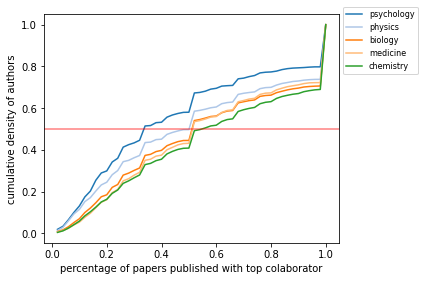

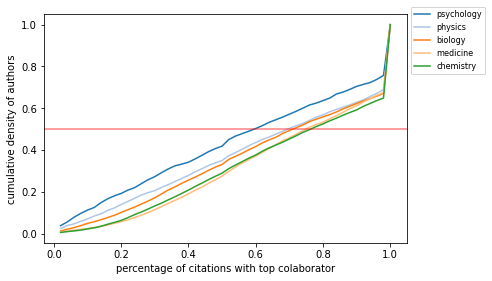

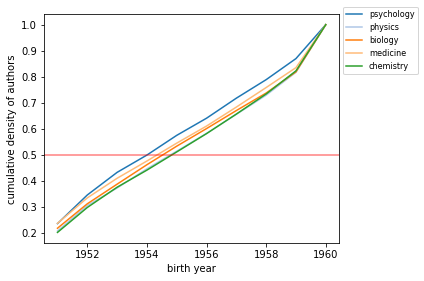

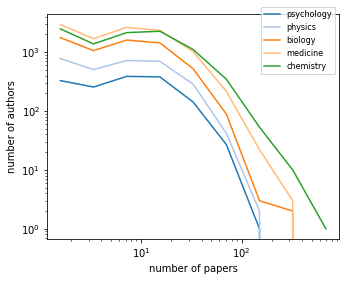

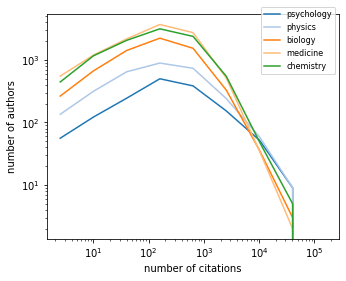

In [59]:
def plot_hist(fig, group, bins, field_name, cumulative):
    y,x = np.histogram(group, bins=bins)
    if cumulative:
        y = np.cumsum(y)
        fig.plot(x[1:], y/y[-1], label=field_name)
    else:
        bins_center = 0.5*(x[:-1]+x[1:])
        fig.plot(bins_center,y, label=field_name)
    
def basic_hist(unique, fos, data, key, suffix, bins, yscale=None, xscale=None, cumulative=False):
    fig, ax = plt.subplots()
    
    for field in unique:
        group = data[fos == field]
        if len(group) < 1000:
            continue
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins, field_name, cumulative)

    ax.legend(bbox_to_anchor=(1.0, 1.05), prop={'size': 8})
    if cumulative:
        ax.axhline(0.5, xmin=0, xmax=1, color='red', alpha=0.5)
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(labels_description[key]['title'])
    ax.set_xlabel(labels_description[key]['x'])
    ax.set_ylabel(labels_description[key]['y'])
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s%s.pdf' % (key,suffix))
    fig.show()

labels_description = {
    'max_colabs': {'x': 'percentage of papers published with top colaborator', 'y': 'cumulative density of authors', 'title': ''},
    'max_ws': {'x': 'percentage of citations with top colaborator', 'y': 'cumulative density of authors', 'title': ''},
    'birth': {'x': 'birth year', 'y': 'cumulative density of authors', 'title': ''},
    'papers': {'x': 'number of papers', 'y': 'number of authors', 'title': ''},
    'total_cits': {'x': 'number of citations', 'y': 'number of authors', 'title': ''} 
}    

basic_hist(fos_sorted, FOS, WP, 'max_colabs', suffix=SUFFIX_STR, bins=50, cumulative=True) # papers
basic_hist(fos_sorted, FOS, WS, 'max_ws', suffix=SUFFIX_STR, bins=50, cumulative=True) # citações
basic_hist(fos_sorted, FOS, Y, 'birth', suffix=SUFFIX_STR, bins=10, cumulative=True)
xspace = np.logspace(np.log10(min(P)), np.log10(max(P)), 10)
basic_hist(fos_sorted, FOS, P, 'papers', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')
xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
basic_hist(fos_sorted, FOS, C, 'total_cits', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')

2 4


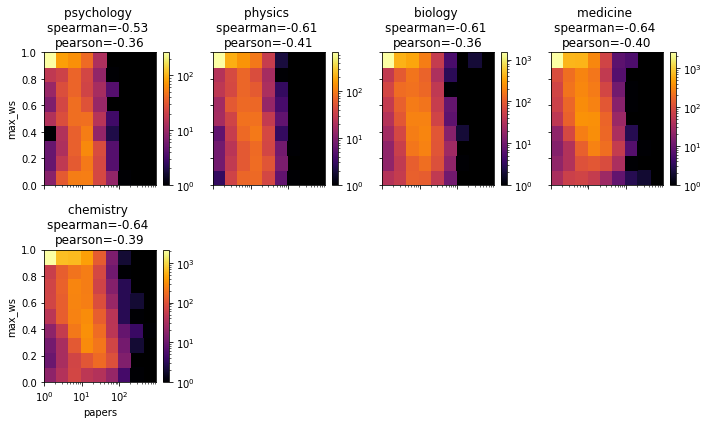

In [63]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im


def get_rows_cols(unique):
    N = len(unique)
    if N % NCOLS == 0:
        rows = N//NCOLS
    else:
        rows = N//NCOLS + 1
    cols = NCOLS
    return rows,cols

    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, suffix, xbins, ybins, yscale=None, xscale=None):
    rows,cols = get_rows_cols(unique)
    print(rows,cols)
    fig, axs = plt.subplots(figsize=(5*rows, 1.5*cols), nrows=rows, ncols=cols, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        if len(xgroup) < 1000:
            continue
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)

        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%cols == 0: 
            ax.set_ylabel(ykey)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xkey)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(unique)%cols
    if empty_plots != 0: 
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s%s.pdf' % (xkey, ykey, suffix))
    fig.show()
    
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, P, WS, 'papers', 'max_ws', SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

2 4


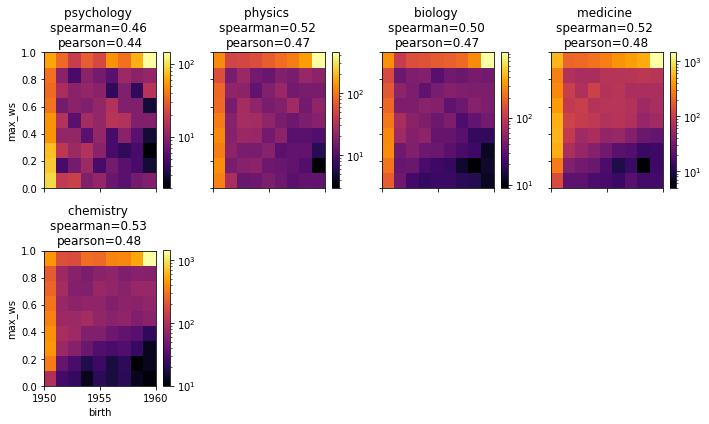

In [64]:
xbins = np.linspace(min(Y), max(Y), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, Y, WS, 'birth', 'max_ws', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale=None, yscale=None)

2 4


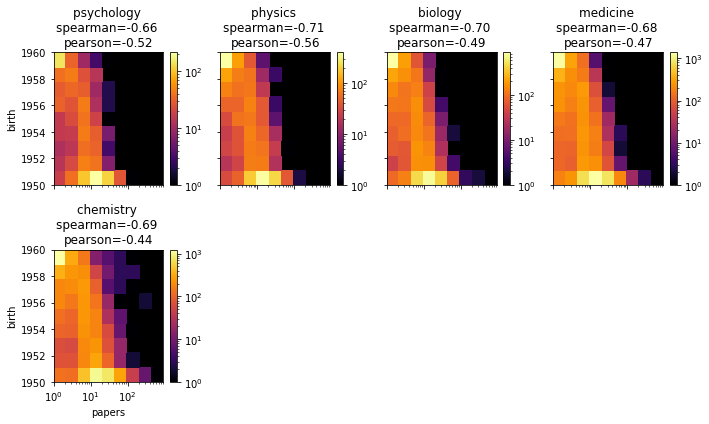

In [65]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, P, Y, 'papers', 'birth', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

2 4


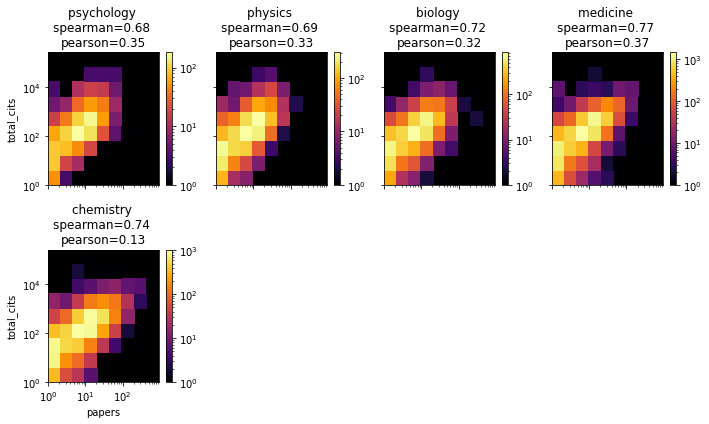

In [66]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
hist2d(fos_sorted, FOS, P, C, 'papers', 'total_cits', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale='log')

2 4


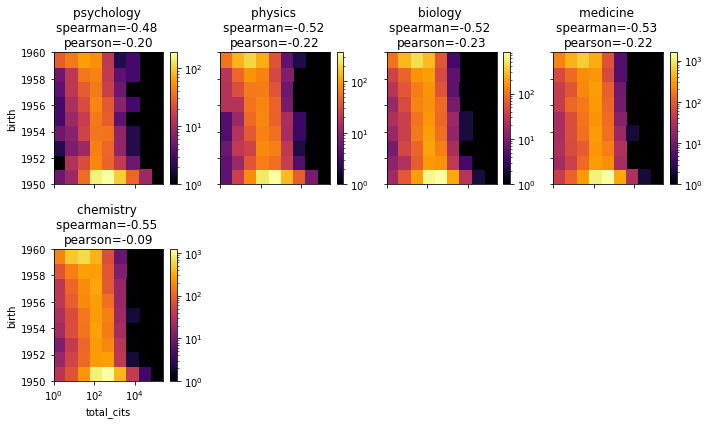

In [67]:
xbins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, C, Y, 'total_cits', 'birth', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

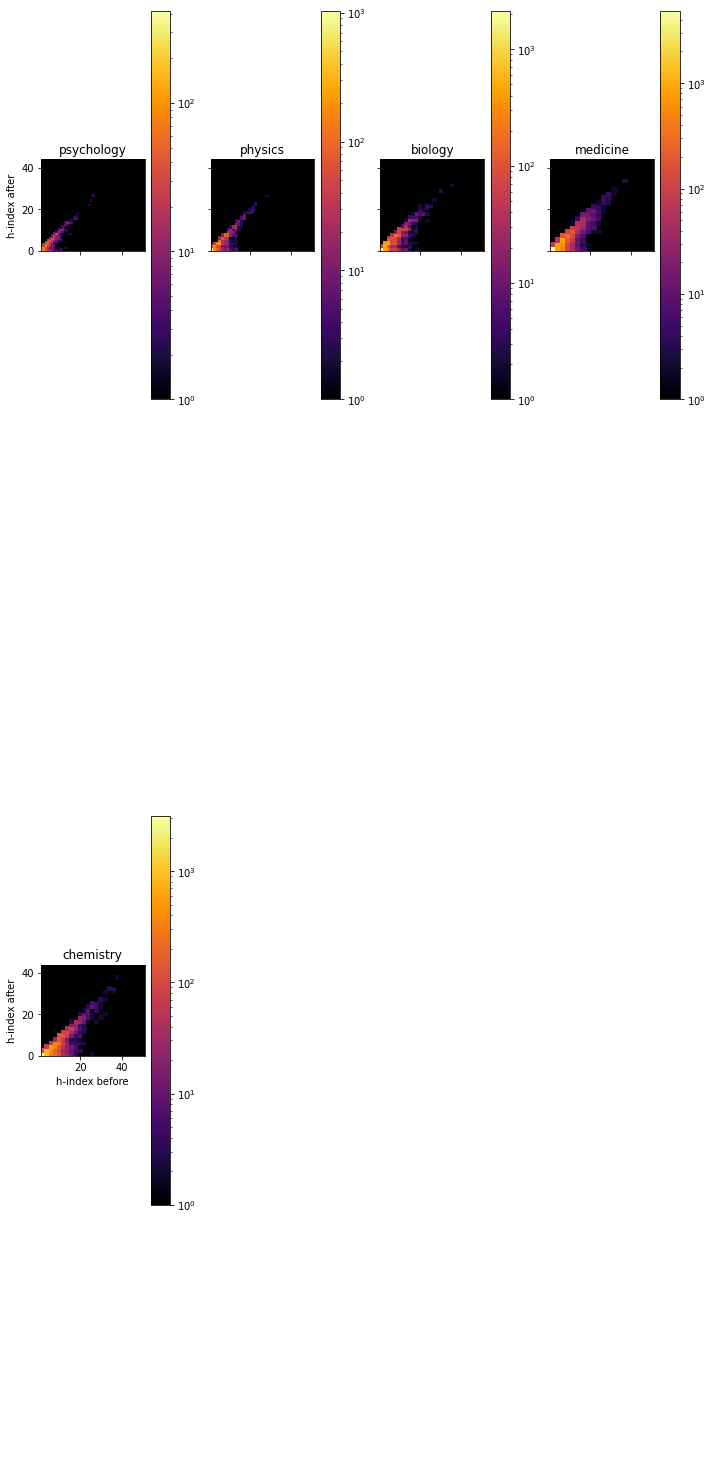

In [68]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    valid_h_index = H[idxs]
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= 100], hindex_after_l1[hindex_before_l1 <= 100], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_aspect('equal')
    ax.set_title(field_name)
    
    return im, hindex_after 


def hindex_before_after(suffix):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(5*rows, 6*cols), nrows=rows, ncols=cols, sharex=True, sharey=True)
    
    i = 0
    hafter_map = {}
    for field in fos_sorted:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _hindex_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%cols == 0: 
            ax.set_ylabel('h-index after')
        if int(i/cols) == rows-1:    
            ax.set_xlabel('h-index before')
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after_%d.pdf' % suffix)
    fig.show()
    
    return hafter_map

hafter_map = hindex_before_after(suffix=SUFFIX)

100%|██████████| 9770/9770 [00:00<00:00, 76969.25it/s]


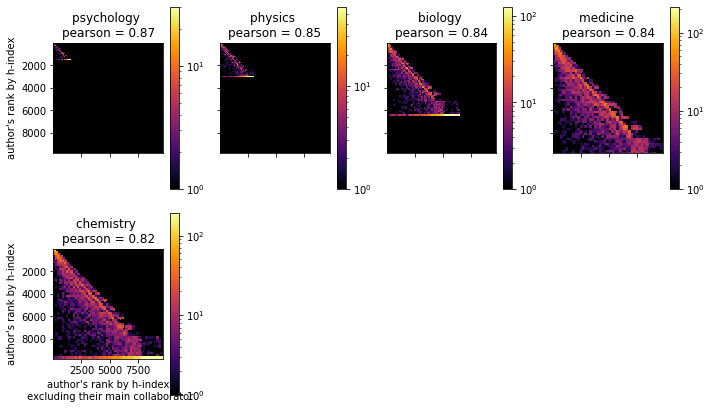

In [70]:
import tqdm
# from tqdm.auto import tqdm

def rank(values, i, new_val):
    old = values[i]
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], old[3])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

def _plot_rank(ax, idxs, hindex_after, field_name):
    valid_h_index = H[idxs]
    
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(np.arange(len(neg_hindex)), valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    ax.set_aspect('equal')
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank(hafter_map, suffix):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(5*rows, 1.5*cols), nrows=rows, ncols=cols, sharex=True, sharey=True)
    
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%cols == 0: 
            ax.set_ylabel('author\'s rank by h-index')
        if int(i/cols) == rows-1:    
            ax.set_xlabel('author\'s rank by h-index\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')

    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank_%d.pdf' % suffix)
    fig.show()
    
plot_rank(hafter_map, suffix=SUFFIX)


In [ ]:
# def _nauthors(f):
#     print(f)
#     chunk = pd.read_csv(f, header=None, sep='\t',
#                 names=['paper_id', 'doi', 'year', 'authors', 'total_cits', 'cits',])
#     nauthors = []
#     for _,row in chunk.iterrows():
#         year = row['year']
#         if not year or type(year) != type(1.0) or year < 1950:
#             continue
#         n = 1 + row['authors'].count(',')
#         nauthors.append(n)
#     del chunk
#     return nauthors

# files_input = glob.glob('data/PaperCompleteInfos_split/*')

# pool = Pool(16)
# nauthors_temp = pool.map(_nauthors, files_input)

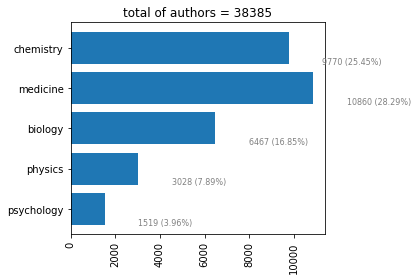

In [71]:
_, count = fos_sort(WS, FOS)
labels = [fos_infos[fos_infos['field_id'] == u].iloc[0, -1] for u in fos_sorted]

plt.barh(np.arange(1, len(count)+1), count, tick_label=labels)
plt.title('total of authors = %d' % len(FOS))
plt.xticks(rotation='vertical')
ax = plt.gca()
for i, v in enumerate(count):
    ax.text(v + 1500, i + .6, "%d (%.2f%%)" % (v, 100*v/len(FOS)), color='gray', size=8)
plt.tight_layout()
plt.savefig('authors_distribution_%d.pdf' % SUFFIX)